Belkacem Sadi LSP2431549

Task1: images classification

This notebook adapts a **pre-trained CLIP (ViT-B/32)** model to a new **3-class** image task using **zero-shot**, **one-shot**, and **few-shot** methods.

I sample **exactly 100 unseen** images from **Open Images V7**, with supports (1-shot and K-shot) kept **disjoint** from the test set.  

Zero-shot uses prompt-based text embeddings; one/few-shot use **class prototypes** built from support image embeddings.  

For each method i sweep a decision **threshold** `T ∈ [0,1]`: accept the top class if `p_max ≥ T`, otherwise **reject** (predict **None**).  

At every `T`, i recompute **Accuracy, Precision, Recall (Recovery), and F1** (per-class plus macro/micro) and report the **acceptance rate**.  

I select the final operating point **T** as the **largest T** on the **maximum macro-F1 plateau** for a fair and selective choice.  

Results include summary tables, **confusion matrices** at `T`, plots of macro-F1 vs `T`.




In [1]:
!pip install -q "sse-starlette<1" fiftyone transformers timm datasets scikit-learn tqdm torch torchvision --upgrade


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:0

In [2]:
import os, random, math, json, time, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F

from transformers import CLIPProcessor, CLIPModel
import fiftyone as fo
import fiftyone.zoo as foz


SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


Using device: cuda


In [3]:
CLASS_NAMES = ["Cat", "Dog", "Bird"]

# Number of evaluation images
N_EVAL_IMAGES = 100

# Few-shot setting (K-shot).
K_FEW = 5

# CLIP backbone
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"

# Threshold sweep settings
THRESHOLDS = np.linspace(0.0, 1.0, 21)

# Baseline threshold (avoid auto-reject with 3 classes)
T0 = max(1.0/len(CLASS_NAMES) - 1e-6, 0.33)
print("Baseline T0:", T0)


Baseline T0: 0.33333233333333334


In [4]:
processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE).eval()
print("CLIP loaded.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP loaded.


In [5]:
def _get_detections_field(dataset):
    """Return the first detections field name """
    schema = dataset.get_field_schema()
    for fname, ftype in schema.items():
        if "Detections" in str(ftype):
            return fname
    return None

def _labels_in_sample(sample, det_field):
    dets = getattr(sample, det_field, None)
    return [d.label for d in dets.detections] if (dets and dets.detections) else []

def _collect_by_class(dataset, class_names, det_field):
    by_class = {c: [] for c in class_names}
    for s in dataset:
        labels = set(_labels_in_sample(s, det_field))
        for c in class_names:
            if c in labels:
                by_class[c].append(s)
    return by_class

def _top_up_to(dataset, exclude_ids, need, det_field):
    """Return up to 'need' extra samples from 'dataset' that contain our classes and are not excluded."""
    extra = []
    for s in dataset:
        if s.id in exclude_ids:
            continue
        labels = set(_labels_in_sample(s, det_field))
        if any(c in labels for c in CLASS_NAMES):
            extra.append(s)
    rng = np.random.default_rng(SEED)
    rng.shuffle(extra)
    return extra[:need]

def load_openimages_subset(class_names, n_test_total=100, k_shot=5, seed=SEED):

    random.seed(seed); np.random.seed(seed)

    # 1) Load validation split containing our classes
    ds_val = foz.load_zoo_dataset(
        "open-images-v7",
        split="validation",
        label_types=["detections"],
        classes=class_names,
        max_samples=None,
        shuffle=True,
        seed=seed,
        only_matching=True,
    )
    det_field = _get_detections_field(ds_val)
    if det_field is None:
        raise RuntimeError("No Detections field found.")

    #  Build supports from validation
    by_class_val = _collect_by_class(ds_val, class_names, det_field)

    support_1shot, support_kshot = {}, {}
    used_ids = set()
    rng = np.random.default_rng(seed)

    for c in class_names:
        candidates = [s for s in by_class_val[c] if s.id not in used_ids]
        if len(candidates) < max(1, k_shot):
            print(f"[WARN] Few candidates in validation for '{c}' ({len(candidates)}).")
        rng.shuffle(candidates)
        # guard for empty
        if len(candidates) == 0:
            raise RuntimeError(f"No validation samples for class '{c}'.")
        support_1shot[c] = [candidates[0]]
        support_kshot[c] = candidates[:min(k_shot, len(candidates))]
        used_ids.update(s.id for s in support_kshot[c])

    #  Assemble unseen test set from validation excluding supports
    remaining_val = [s for s in ds_val if s.id not in used_ids]
    rng.shuffle(remaining_val)
    test_samples = remaining_val[:n_test_total]

    #  Top up from train split if needed
    if len(test_samples) < n_test_total:
        need = n_test_total - len(test_samples)
        print(f"[INFO] Topping up {need} images from train split to reach exactly {n_test_total}.")
        ds_train = foz.load_zoo_dataset(
            "open-images-v7",
            split="train",
            label_types=["detections"],
            classes=class_names,
            max_samples=None,
            shuffle=True,
            seed=seed,
            only_matching=True,
        )
        det_field_train = _get_detections_field(ds_train) or det_field
        extra = _top_up_to(ds_train, exclude_ids=used_ids.union({s.id for s in test_samples}),
                           need=need, det_field=det_field_train)
        test_samples += extra

    print(f"Support: 1-shot per class; {k_shot}-shot per class.")
    print(f"Final test set size: {len(test_samples)}")


    def count_by_class(samples):
        counts = {c:0 for c in class_names}
        for s in samples:
            labels = set(_labels_in_sample(s, det_field))
            for c in class_names:
                if c in labels:
                    counts[c]+=1
        return counts

    print("Support 1-shot counts:", {c: len(v) for c,v in support_1shot.items()})
    print("Support K-shot counts:", {c: len(v) for c,v in support_kshot.items()})
    print("Test class presence counts:", count_by_class(test_samples))

    return support_1shot, support_kshot, test_samples, {"val": ds_val}, det_field


In [6]:
from PIL import Image

# A small set of CLIP-style prompt templates to stabilize zero-shot
PROMPT_TEMPLATES = [
    "a photo of a {}",
    "a close-up photo of a {}",
    "a photo of the {}",
    "a cropped photo of a {}",
    "a low resolution photo of a {}",
    "a bright photo of a {}",
    "a photo of one {}",
    "{}",
]

@torch.no_grad()
def get_image_embeddings(samples):
    ims = []
    for s in samples:
        ims.append(Image.open(s.filepath).convert("RGB"))
    inputs = processor(images=ims, return_tensors="pt", padding=True).to(DEVICE)
    feats = clip_model.get_image_features(**inputs)
    feats = F.normalize(feats, dim=-1)
    return feats  # [N,D]

@torch.no_grad()
def get_text_embeddings(class_names, templates=PROMPT_TEMPLATES):
    # Average text embeddings across templates
    all_embeds = []
    for tmpl in templates:
        texts = [tmpl.format(c) for c in class_names]
        inputs = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
        embeds = clip_model.get_text_features(**inputs)
        embeds = F.normalize(embeds, dim=-1)  # [C,D]
        all_embeds.append(embeds)
    text_embeds = torch.stack(all_embeds, dim=0).mean(dim=0)
    text_embeds = F.normalize(text_embeds, dim=-1)
    return text_embeds  # [C,D]


In [7]:
def build_prototypes(support_dict):

    class_names = list(support_dict.keys())
    protos = []
    for c in class_names:
        embeds = get_image_embeddings(support_dict[c])
        proto = embeds.mean(dim=0, keepdim=True)
        proto = F.normalize(proto, dim=-1)
        protos.append(proto)
    prototypes = torch.cat(protos, dim=0)
    return class_names, prototypes


In [8]:
@torch.no_grad()
def predict_zeroshot(image_embeds, class_names):
    text_embeds = get_text_embeddings(class_names)
    logits = image_embeds @ text_embeds.T
    probs = logits.softmax(dim=1)
    return probs

@torch.no_grad()
def predict_with_prototypes(image_embeds, class_names, prototypes):
    sims = image_embeds @ prototypes.T
    probs = sims.softmax(dim=1)
    return probs


In [9]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from IPython.display import display

def apply_threshold(probs, class_names, T):
    """Global threshold T."""
    top_p, top_idx = probs.max(dim=1)
    preds = []
    for p, idx in zip(top_p.cpu().tolist(), top_idx.cpu().tolist()):
        preds.append(class_names[idx] if p >= T else None)
    return preds

def apply_threshold_per_class(probs, class_names, T_map):
    """
    Per-class thresholds T_map: {"Cat":0.55, "Dog":0.45, "Bicycle":0.6}
    Pick the highest class whose prob >= its threshold; else reject.
    """
    probs_np = probs.detach().cpu().numpy()
    preds = []
    for row in probs_np:
        best = None; best_p = -1.0
        for j, c in enumerate(class_names):
            t = float(T_map.get(c, 0.5))
            if row[j] >= t and row[j] > best_p:
                best, best_p = c, row[j]
        preds.append(best)  # may be None
    return preds

def compute_metrics(preds, truths, class_names):
    """
    Returns (per_class_df, summary_dict, extra_dict)
    - per_class_df: precision/recall/f1/support for each class
    - summary_dict: accuracy + macro/micro
    - extra_dict: acceptance_rate, rejected_count
    """
    labels_all = class_names
    y_true = pd.Series(truths)
    y_pred = pd.Series(preds).fillna("None")

    # Acceptance rate
    acceptance_rate = (y_pred != "None").mean()
    rejected_count = (y_pred == "None").sum()

    # Accuracy
    acc = accuracy_score(y_true, y_pred.replace("None", "___NONE___"))

    pr, rc, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_all, zero_division=0, average=None
    )
    macro = precision_recall_fscore_support(y_true, y_pred, labels=labels_all, zero_division=0, average="macro")
    micro = precision_recall_fscore_support(y_true, y_pred, labels=labels_all, zero_division=0, average="micro")

    per_class = pd.DataFrame({
        "class": labels_all,
        "precision": pr,
        "recall": rc,
        "f1": f1,
        "support": support
    })

    summary = {
        "accuracy": acc,
        "macro_precision": macro[0],
        "macro_recall": macro[1],
        "macro_f1": macro[2],
        "micro_precision": micro[0],
        "micro_recall": micro[1],
        "micro_f1": micro[2],
    }
    extra = {"acceptance_rate": float(acceptance_rate), "rejected_count": int(rejected_count)}
    return per_class, summary, extra

def sweep_thresholds_global(all_probs, truths, class_names, thresholds):
    rows = []
    for T in thresholds:
        preds = apply_threshold(all_probs, class_names, float(T))
        _, summary, extra = compute_metrics(preds, truths, class_names)
        summary.update({"threshold": float(T), **extra})
        rows.append(summary)
    return pd.DataFrame(rows)

def sweep_thresholds_per_class(all_probs, truths, class_names, thresholds):
    """Per-class metrics at each T (global T)."""
    dfs = []
    for T in thresholds:
        preds = apply_threshold(all_probs, class_names, float(T))
        per_class_df, _, extra = compute_metrics(preds, truths, class_names)
        per_class_df["threshold"] = float(T)
        per_class_df["acceptance_rate"] = extra["acceptance_rate"]
        dfs.append(per_class_df)
    return pd.concat(dfs, ignore_index=True)


In [11]:
#  Load data
support_1, support_k, test_samples, datasets, det_field = load_openimages_subset(
    CLASS_NAMES, n_test_total=N_EVAL_IMAGES, k_shot=K_FEW, seed=SEED
)

#  Single-label truth for metrics
truths = []
for s in test_samples:
    labels = _labels_in_sample(s, det_field)
    assigned = next((c for c in CLASS_NAMES if c in labels), None)
    truths.append(assigned)

#  Embeddings
test_embeds = get_image_embeddings(test_samples)

# Prototype sets
classes_1, protos_1 = build_prototypes(support_1)
classes_k, protos_k = build_prototypes(support_k)
assert classes_1 == classes_k == CLASS_NAMES, "Class order mismatch"

# Predictions
probs_zero = predict_zeroshot(test_embeds, CLASS_NAMES)
probs_1    = predict_with_prototypes(test_embeds, CLASS_NAMES, protos_1)
probs_k    = predict_with_prototypes(test_embeds, CLASS_NAMES, protos_k)

# Quick sanity: top-p distributions
for name, P in [("zero-shot", probs_zero), ("one-shot", probs_1), ("few-shot", probs_k)]:
    tp = P.max(dim=1).values.cpu().numpy()
    print(f"{name} top-p: min={tp.min():.3f}, median={np.median(tp):.3f}, mean={tp.mean():.3f}, max={tp.max():.3f}")

# Baseline metrics at T0
preds_zero = apply_threshold(probs_zero, CLASS_NAMES, T0)
preds_1    = apply_threshold(probs_1,    CLASS_NAMES, T0)
preds_k    = apply_threshold(probs_k,    CLASS_NAMES, T0)

pc_zero, sm_zero, ex_zero = compute_metrics(preds_zero, truths, CLASS_NAMES)
pc_one,  sm_one,  ex_one  = compute_metrics(preds_1,    truths, CLASS_NAMES)
pc_few,  sm_few,  ex_few  = compute_metrics(preds_k,    truths, CLASS_NAMES)

print("\n=== Baseline @ T0 ≈ {:.2f} ===".format(T0))
print("Zero-shot:", {**sm_zero, **ex_zero})
print("One-shot :", {**sm_one,  **ex_one})
print("Few-shot :", {**sm_few,  **ex_few})

display(pc_zero); display(pc_one); display(pc_few)

# Threshold sweeps
sweep_zero   = sweep_thresholds_global(probs_zero, truths, CLASS_NAMES, THRESHOLDS)
sweep_one    = sweep_thresholds_global(probs_1,    truths, CLASS_NAMES, THRESHOLDS)
sweep_few    = sweep_thresholds_global(probs_k,    truths, CLASS_NAMES, THRESHOLDS)

pc_sweep_zero = sweep_thresholds_per_class(probs_zero, truths, CLASS_NAMES, THRESHOLDS)
pc_sweep_one  = sweep_thresholds_per_class(probs_1,    truths, CLASS_NAMES, THRESHOLDS)
pc_sweep_few  = sweep_thresholds_per_class(probs_k,    truths, CLASS_NAMES, THRESHOLDS)

print("\nSweep (macro/micro + acceptance): zero/one/few")
display(sweep_zero); display(sweep_one); display(sweep_few)

print("\nPer-class sweep (first rows):")
display(pc_sweep_zero.head()); display(pc_sweep_one.head()); display(pc_sweep_few.head())


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v7/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v7/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v7/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpwzm5a4ch/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv' to '/root/fiftyone/open-images-v7/validation/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 2521 images


 100% |█████████████████| 2521/2521 [4.9m elapsed, 0s remaining, 8.0 files/s]       


INFO:eta.core.utils: 100% |█████████████████| 2521/2521 [4.9m elapsed, 0s remaining, 8.0 files/s]       


Dataset info written to '/root/fiftyone/open-images-v7/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v7/info.json'


You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information


Loading 'open-images-v7' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v7' split 'validation'


 100% |███████████████| 2521/2521 [6.3s elapsed, 0s remaining, 431.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 2521/2521 [6.3s elapsed, 0s remaining, 431.8 samples/s]      


Dataset 'open-images-v7-validation-None' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v7-validation-None' created


Support: 1-shot per class; 5-shot per class.
Final test set size: 100
Support 1-shot counts: {'Cat': 1, 'Dog': 1, 'Bird': 1}
Support K-shot counts: {'Cat': 5, 'Dog': 5, 'Bird': 5}
Test class presence counts: {'Cat': 13, 'Dog': 68, 'Bird': 21}
zero-shot top-p: min=0.341, median=0.348, mean=0.348, max=0.354
one-shot top-p: min=0.335, median=0.358, mean=0.358, max=0.384
few-shot top-p: min=0.341, median=0.362, mean=0.363, max=0.384

=== Baseline @ T0 ≈ 0.33 ===
Zero-shot: {'accuracy': 0.99, 'macro_precision': 0.9950980392156863, 'macro_recall': 0.9743589743589745, 'macro_f1': 0.9841975308641975, 'micro_precision': 0.99, 'micro_recall': 0.99, 'micro_f1': 0.99, 'acceptance_rate': 1.0, 'rejected_count': 0}
One-shot : {'accuracy': 0.82, 'macro_precision': 0.7829892734264319, 'macro_recall': 0.805223880597015, 'macro_f1': 0.7479166666666667, 'micro_precision': 0.82, 'micro_recall': 0.82, 'micro_f1': 0.82, 'acceptance_rate': 1.0, 'rejected_count': 0}
Few-shot : {'accuracy': 0.98, 'macro_precisi

,class,precision,recall,f1,support
0,Cat,1.000000,0.923077,0.960000,13
1,Dog,0.985294,1.000000,0.992593,67
2,Bird,1.000000,1.000000,1.000000,20


,class,precision,recall,f1,support
0,Cat,0.481481,1.000000,0.65000,13
1,Dog,0.950820,0.865672,0.90625,67
2,Bird,0.916667,0.550000,0.68750,20


,class,precision,recall,f1,support
0,Cat,0.923077,0.923077,0.923077,13
1,Dog,1.000000,0.985075,0.992481,67
2,Bird,0.952381,1.000000,0.975610,20



Sweep (macro/micro + acceptance): zero/one/few


,accuracy,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,threshold,acceptance_rate,rejected_count
0,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.00,1.00,0
1,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.05,1.00,0
2,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.10,1.00,0
3,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.15,1.00,0
4,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.20,1.00,0
5,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.25,1.00,0
6,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.990000,0.30,1.00,0
7,0.24,0.666667,0.271393,0.356643,1.00,0.24,0.387097,0.35,0.24,76
8,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.40,0.00,100
9,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.45,0.00,100


,accuracy,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,threshold,acceptance_rate,rejected_count
0,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.00,1.00,0
1,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.05,1.00,0
2,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.10,1.00,0
3,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.15,1.00,0
4,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.20,1.00,0
5,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.25,1.00,0
6,0.82,0.782989,0.805224,0.747917,0.820000,0.82,0.820000,0.30,1.00,0
7,0.66,0.800000,0.632090,0.630860,0.891892,0.66,0.758621,0.35,0.74,26
8,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.40,0.00,100
9,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.45,0.00,100


,accuracy,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,threshold,acceptance_rate,rejected_count
0,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.00,1.00,0
1,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.05,1.00,0
2,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.10,1.00,0
3,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.15,1.00,0
4,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.20,1.00,0
5,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.25,1.00,0
6,0.98,0.958486,0.969384,0.963723,0.980000,0.98,0.980000,0.30,1.00,0
7,0.92,0.958486,0.939533,0.947856,0.978723,0.92,0.948454,0.35,0.94,6
8,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.40,0.00,100
9,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.45,0.00,100



Per-class sweep (first rows):


,class,precision,recall,f1,support,threshold,acceptance_rate
0,Cat,1.000000,0.923077,0.960000,13.0,0.00,1.0
1,Dog,0.985294,1.000000,0.992593,67.0,0.00,1.0
2,Bird,1.000000,1.000000,1.000000,20.0,0.00,1.0
3,Cat,1.000000,0.923077,0.960000,13.0,0.05,1.0
4,Dog,0.985294,1.000000,0.992593,67.0,0.05,1.0


,class,precision,recall,f1,support,threshold,acceptance_rate
0,Cat,0.481481,1.000000,0.65000,13.0,0.00,1.0
1,Dog,0.950820,0.865672,0.90625,67.0,0.00,1.0
2,Bird,0.916667,0.550000,0.68750,20.0,0.00,1.0
3,Cat,0.481481,1.000000,0.65000,13.0,0.05,1.0
4,Dog,0.950820,0.865672,0.90625,67.0,0.05,1.0


,class,precision,recall,f1,support,threshold,acceptance_rate
0,Cat,0.923077,0.923077,0.923077,13.0,0.00,1.0
1,Dog,1.000000,0.985075,0.992481,67.0,0.00,1.0
2,Bird,0.952381,1.000000,0.975610,20.0,0.00,1.0
3,Cat,0.923077,0.923077,0.923077,13.0,0.05,1.0
4,Dog,1.000000,0.985075,0.992481,67.0,0.05,1.0


In [12]:
def best_threshold_maxT(sweep_df, metric="macro_f1", eps=1e-9):

    m = sweep_df[metric].max()
    plateau = sweep_df[abs(sweep_df[metric] - m) <= eps].copy()
    plateau = plateau.sort_values("threshold")
    row = plateau.iloc[-1]  # largest T on plateau
    return float(row["threshold"]), row.to_dict()

Tz, row_z = best_threshold_maxT(sweep_zero)
To, row_o = best_threshold_maxT(sweep_one)
Tf, row_f = best_threshold_maxT(sweep_few)

print(f"Best T (zero-shot): {Tz:.2f}", row_z)
print(f"Best T (one-shot) : {To:.2f}", row_o)
print(f"Best T (few-shot) : {Tf:.2f}", row_f)

def eval_at_T(probs, T):
    preds = apply_threshold(probs, CLASS_NAMES, T)
    per_class, summary, extra = compute_metrics(preds, truths, CLASS_NAMES)
    return per_class, summary, extra, preds

pc_z, sm_z, ex_z, preds_z = eval_at_T(probs_zero, Tz)
pc_o, sm_o, ex_o, preds_o = eval_at_T(probs_1,    To)
pc_f, sm_f, ex_f, preds_f = eval_at_T(probs_k,    Tf)

summary_table = pd.DataFrame([
    {"method":"zero-shot", **sm_z, **ex_z, "T*":Tz},
    {"method":"one-shot",  **sm_o, **ex_o, "T*":To},
    {"method":"few-shot",  **sm_f, **ex_f, "T*":Tf},
])
display(summary_table)


Best T (zero-shot): 0.30 {'accuracy': 0.99, 'macro_precision': 0.9950980392156863, 'macro_recall': 0.9743589743589745, 'macro_f1': 0.9841975308641975, 'micro_precision': 0.99, 'micro_recall': 0.99, 'micro_f1': 0.99, 'threshold': 0.30000000000000004, 'acceptance_rate': 1.0, 'rejected_count': 0.0}
Best T (one-shot) : 0.30 {'accuracy': 0.82, 'macro_precision': 0.7829892734264319, 'macro_recall': 0.805223880597015, 'macro_f1': 0.7479166666666667, 'micro_precision': 0.82, 'micro_recall': 0.82, 'micro_f1': 0.82, 'threshold': 0.30000000000000004, 'acceptance_rate': 1.0, 'rejected_count': 0.0}
Best T (few-shot) : 0.30 {'accuracy': 0.98, 'macro_precision': 0.9584859584859585, 'macro_recall': 0.9693838499808649, 'macro_f1': 0.9637226273940009, 'micro_precision': 0.98, 'micro_recall': 0.98, 'micro_f1': 0.98, 'threshold': 0.30000000000000004, 'acceptance_rate': 1.0, 'rejected_count': 0.0}


,method,accuracy,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,acceptance_rate,rejected_count,T*
0,zero-shot,0.99,0.995098,0.974359,0.984198,0.99,0.99,0.99,1.0,0,0.3
1,one-shot,0.82,0.782989,0.805224,0.747917,0.82,0.82,0.82,1.0,0,0.3
2,few-shot,0.98,0.958486,0.969384,0.963723,0.98,0.98,0.98,1.0,0,0.3


In [13]:
from sklearn.metrics import confusion_matrix
labels_cm = CLASS_NAMES + ["None"]

def cm_for(preds):
    return pd.DataFrame(
        confusion_matrix(truths, [p if p is not None else "None" for p in preds], labels=labels_cm),
        index=[f"true_{l}" for l in labels_cm],
        columns=[f"pred_{l}" for l in labels_cm]
    )

print("Confusion matrix — zero-shot @ T*")
display(cm_for(preds_z))
print("Confusion matrix — one-shot @ T*")
display(cm_for(preds_o))
print("Confusion matrix — few-shot @ T*")
display(cm_for(preds_f))


Confusion matrix — zero-shot @ T*


,pred_Cat,pred_Dog,pred_Bird,pred_None
true_Cat,12,1,0,0
true_Dog,0,67,0,0
true_Bird,0,0,20,0
true_None,0,0,0,0


Confusion matrix — one-shot @ T*


,pred_Cat,pred_Dog,pred_Bird,pred_None
true_Cat,13,0,0,0
true_Dog,8,58,1,0
true_Bird,6,3,11,0
true_None,0,0,0,0


Confusion matrix — few-shot @ T*


,pred_Cat,pred_Dog,pred_Bird,pred_None
true_Cat,12,0,1,0
true_Dog,1,66,0,0
true_Bird,0,0,20,0
true_None,0,0,0,0


In [ ]:
# Example per-class thresholds
T_MAP = {c: 0.30 for c in CLASS_NAMES}

preds_zero_pc = apply_threshold_per_class(probs_zero, CLASS_NAMES, T_MAP)
pc_zero_pc, sm_zero_pc, ex_zero_pc = compute_metrics(preds_zero_pc, truths, CLASS_NAMES)
print("Zero-shot (per-class thresholds):", {**sm_zero_pc, **ex_zero_pc})
display(pc_zero_pc)


Zero-shot (per-class thresholds): {'accuracy': 0.99, 'macro_precision': 0.9950980392156863, 'macro_recall': 0.9743589743589745, 'macro_f1': 0.9841975308641975, 'micro_precision': 0.99, 'micro_recall': 0.99, 'micro_f1': 0.99, 'acceptance_rate': 1.0, 'rejected_count': 0}


,class,precision,recall,f1,support
0,Cat,1.000000,0.923077,0.960000,13
1,Dog,0.985294,1.000000,0.992593,67
2,Bird,1.000000,1.000000,1.000000,20


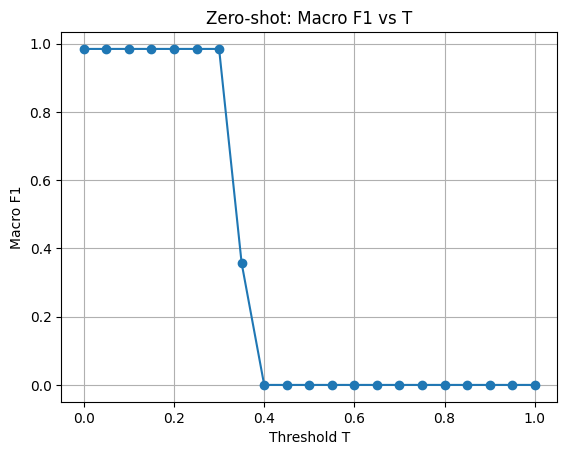

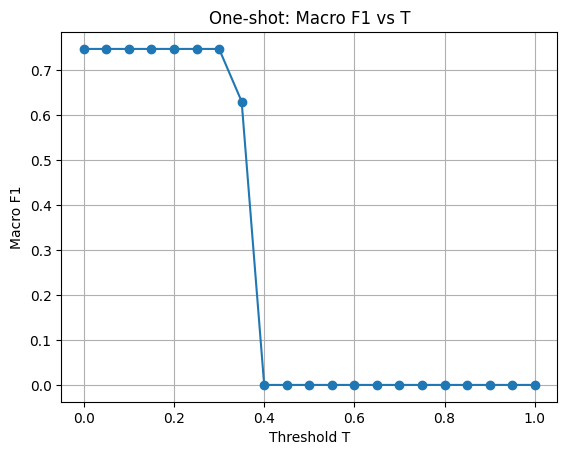

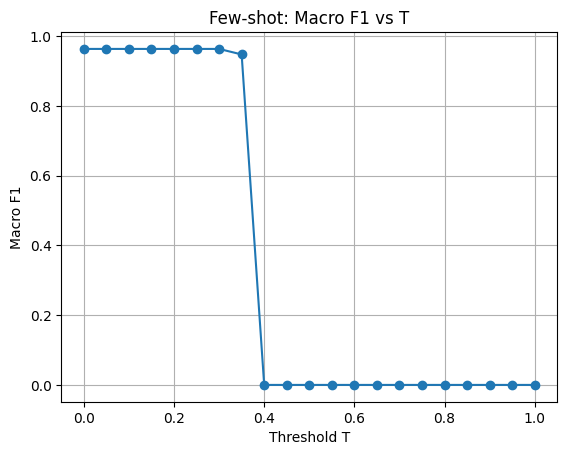

In [14]:
import matplotlib.pyplot as plt

def plot_metric(df, title):
    plt.figure()
    plt.plot(df["threshold"], df["macro_f1"], marker="o")
    plt.xlabel("Threshold T")
    plt.ylabel("Macro F1")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_metric(sweep_zero, "Zero-shot: Macro F1 vs T")
plot_metric(sweep_one,  "One-shot: Macro F1 vs T")
plot_metric(sweep_few,  "Few-shot: Macro F1 vs T")


In [15]:
import io, requests
from PIL import Image

@torch.no_grad()
def probs_and_pred_from_pil(pil_img, method="zero", T=0.30):
    inputs = processor(images=[pil_img], return_tensors="pt").to(DEVICE)
    img_emb = F.normalize(clip_model.get_image_features(**inputs), dim=-1)
    if method == "zero":
        text_emb = get_text_embeddings(CLASS_NAMES)
        probs = (img_emb @ text_emb.T).softmax(dim=1)
    elif method == "one":
        _, protos_1 = build_prototypes(support_1)
        probs = (img_emb @ protos_1.T).softmax(dim=1)
    else:
        _, protos_k = build_prototypes(support_k)
        probs = (img_emb @ protos_k.T).softmax(dim=1)
    pred = apply_threshold(probs, CLASS_NAMES, T)[0]
    return probs.squeeze(0).cpu().numpy(), pred

# Internet image
#url = "/content/good-advice-puppy-play-bow.jpg"
#pil = Image.open(io.BytesIO(requests.get(url).content)).convert("RGB")

pil = Image.open("/content/beagle-hound-dog.jpg").convert("RGB")
p_zero, pred_zero = probs_and_pred_from_pil(pil, "zero", Tz)
p_one,  pred_one  = probs_and_pred_from_pil(pil, "one",  To)
p_few,  pred_few  = probs_and_pred_from_pil(pil, "few",  Tf)
print("Internet image → zero/one/few:", pred_zero, pred_one, pred_few)

# 2) None-of-the-objects (solid or noise)
noise = Image.fromarray((np.random.rand(224,224,3)*255).astype("uint8"))
_, none_pred = probs_and_pred_from_pil(noise, "zero", Tz)
print("Random noise →", none_pred)


Internet image → zero/one/few: Dog Dog Dog
Random noise → Cat
